In [1]:
import numpy as np
import model

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.utils                          import R_trendfilter

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

Signal-to-noise ratio: 169.569


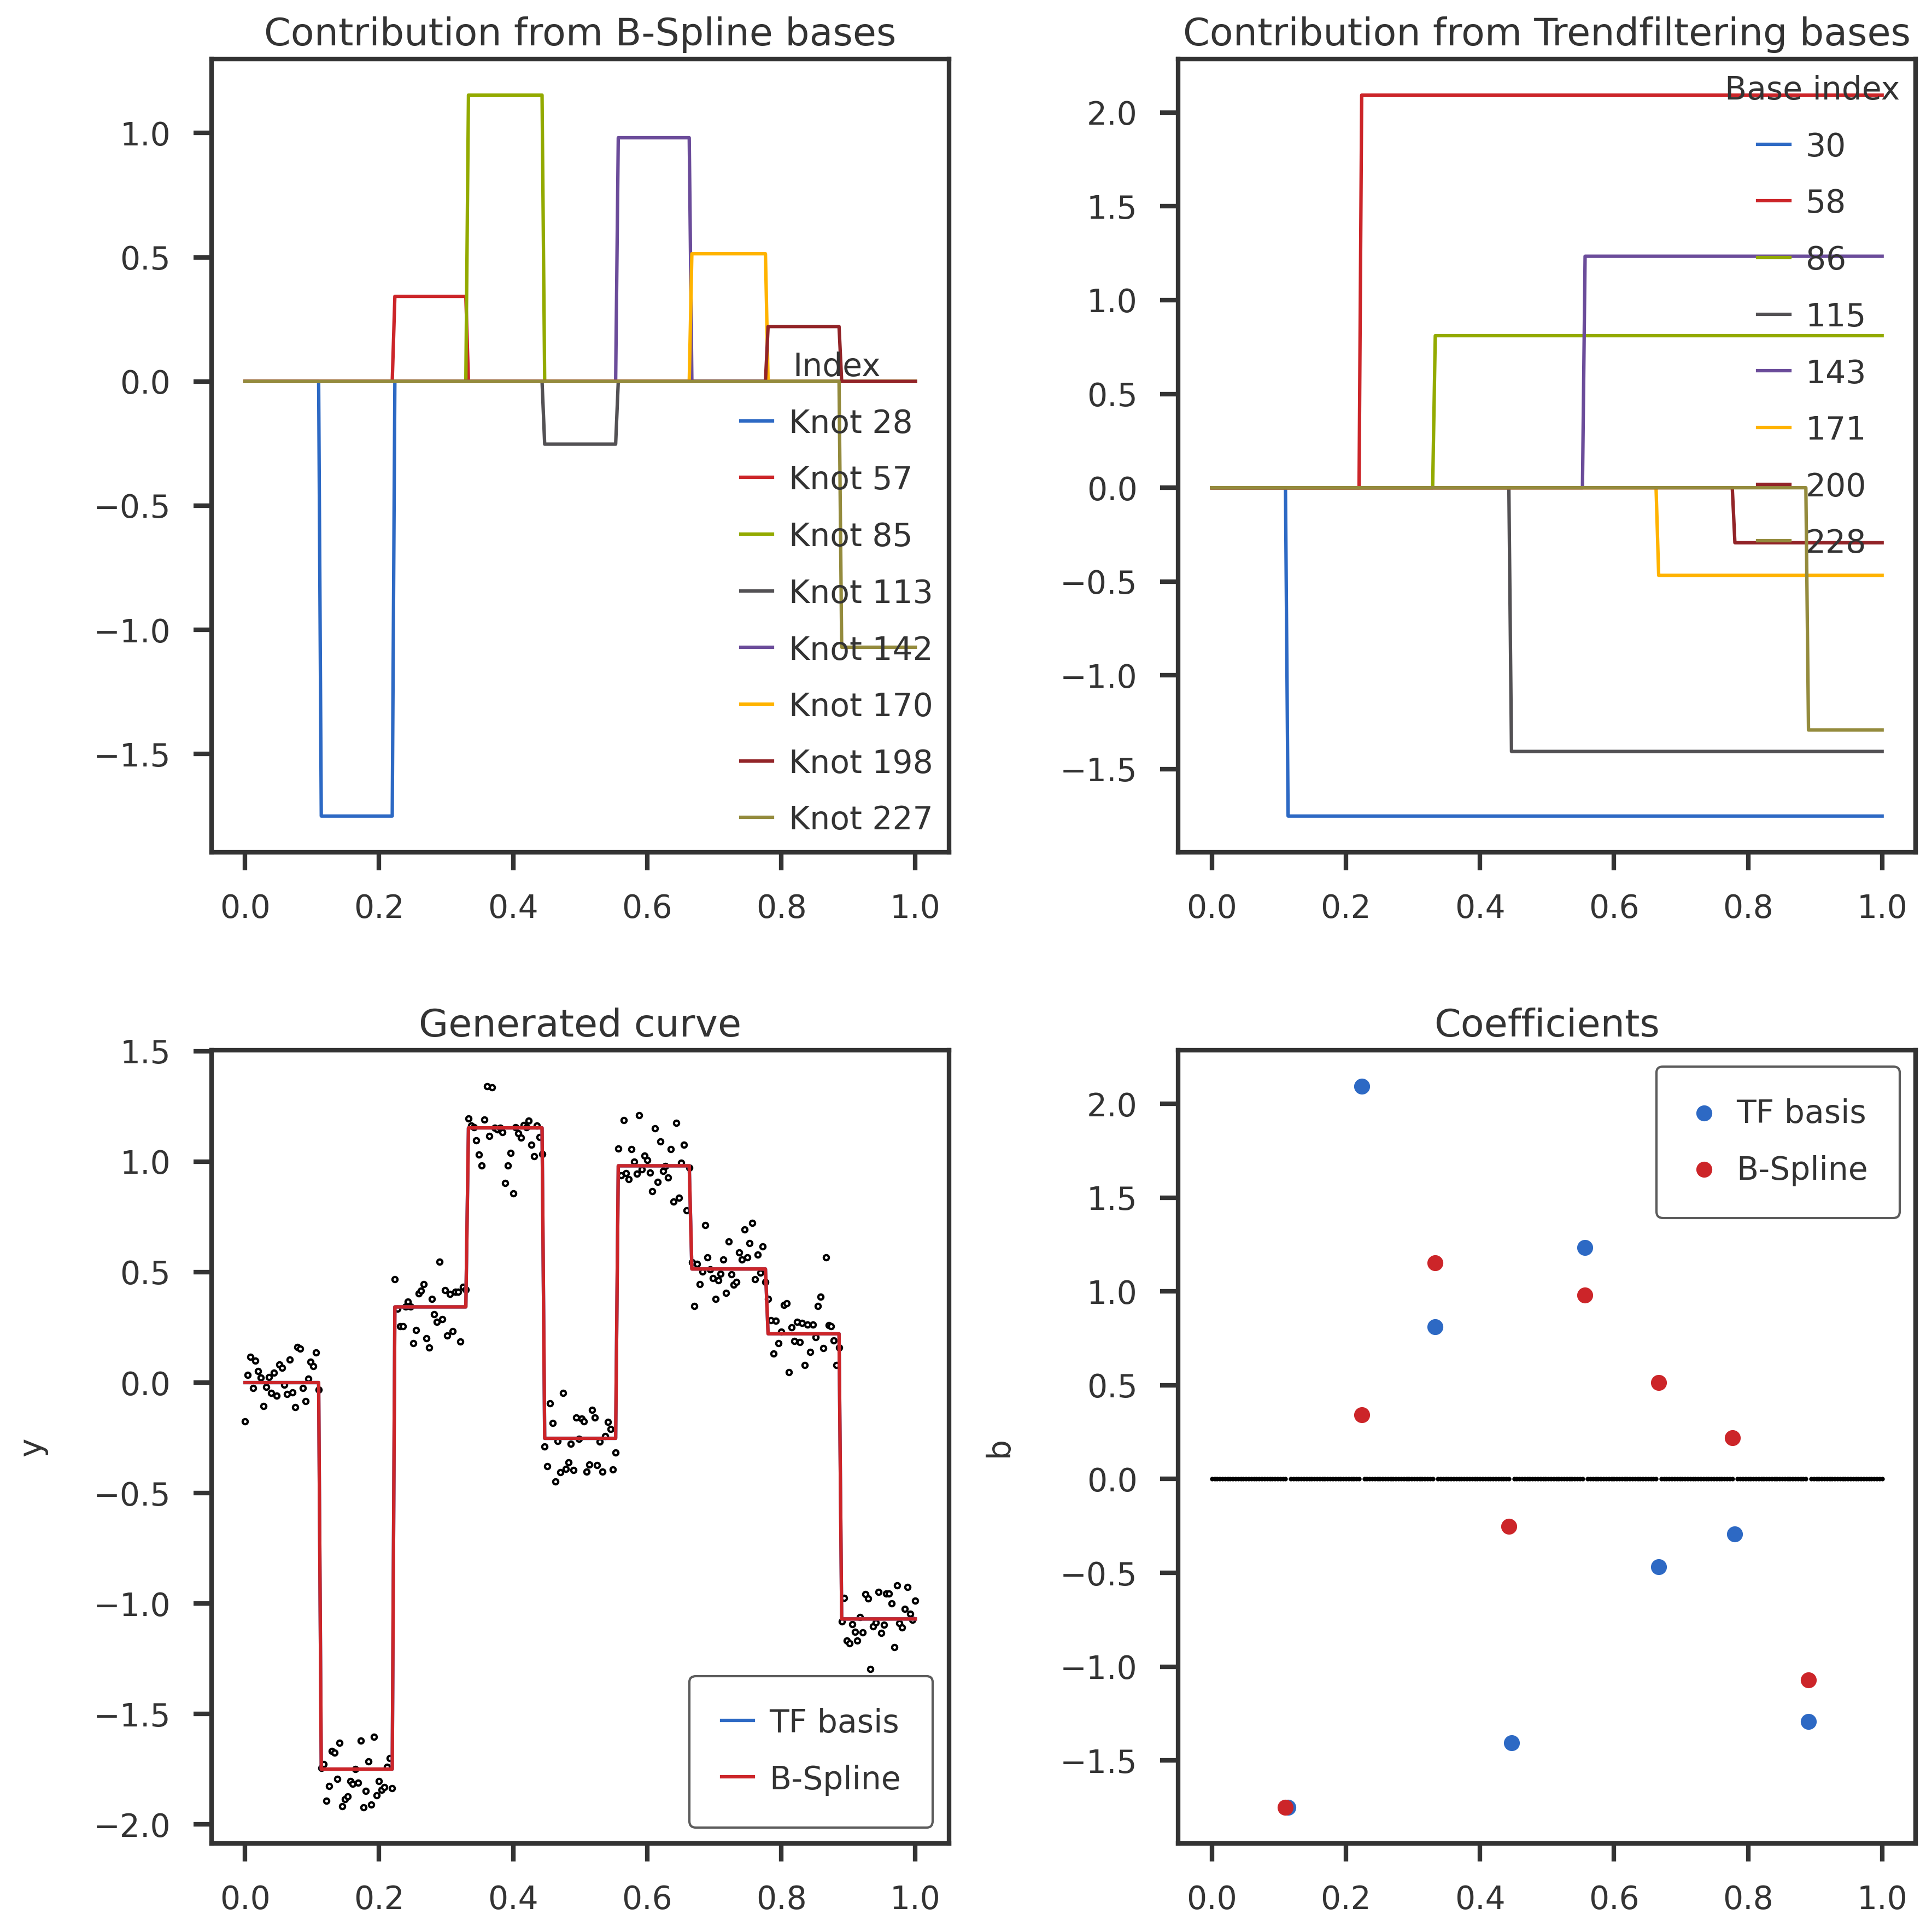

In [2]:
n = 256
x = np.linspace(0, 1, n)
np.random.seed(100)

# Zeroth degree trendfiltering
nknots = 8
degree = 0
strue = 0.1
include_intercept = False
knots = np.linspace(0, 1, nknots+2)[1:-1]
bfix = np.random.normal(0, 1, size = nknots + degree)


H, y, ytest, btrue, snr, G, Gb = model.changepoint_from_bspline(x, knots, strue, 
                                            degree = degree, 
                                            signal = "fixed", bfix = bfix,
                                            seed = 100, include_intercept = include_intercept,
                                            get_bsplines = True, eps = 1e-8
                                           )
print(f"Signal-to-noise ratio: {snr:.3f}")

fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, H, btrue)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

In [3]:
def center_and_scale_tfbasis(Z, b):
    '''
    Basis matrix Z is always 2D.
    b is the coefficient vector
    The first column of Z is all 1, hence it has zero standard deviation.
    '''
    dim  = Z.ndim
    std  = np.std(Z, axis = 0)
    if std[0] == 0:
        # do not scale the first column
        std[0] = 1.0
    Znew = Z / std
    Znew[:, 1:] = Znew[:, 1:] - np.mean(Znew[:, 1:], axis = 0).reshape(1, -1)
    bnew = b * std
    ## add the intercept
    bnew[0] = - np.sum(Znew[0, :] * bnew)
    '''
    alternative
    bnew = np.dot(np.dot(np.linalg.inv(Znew), Z), b)
    '''
    return Znew, bnew

Hscale, bscale = center_and_scale_tfbasis(H, btrue)
dj = np.sum(np.square(Hscale), axis = 0)
print (dj)

[256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 

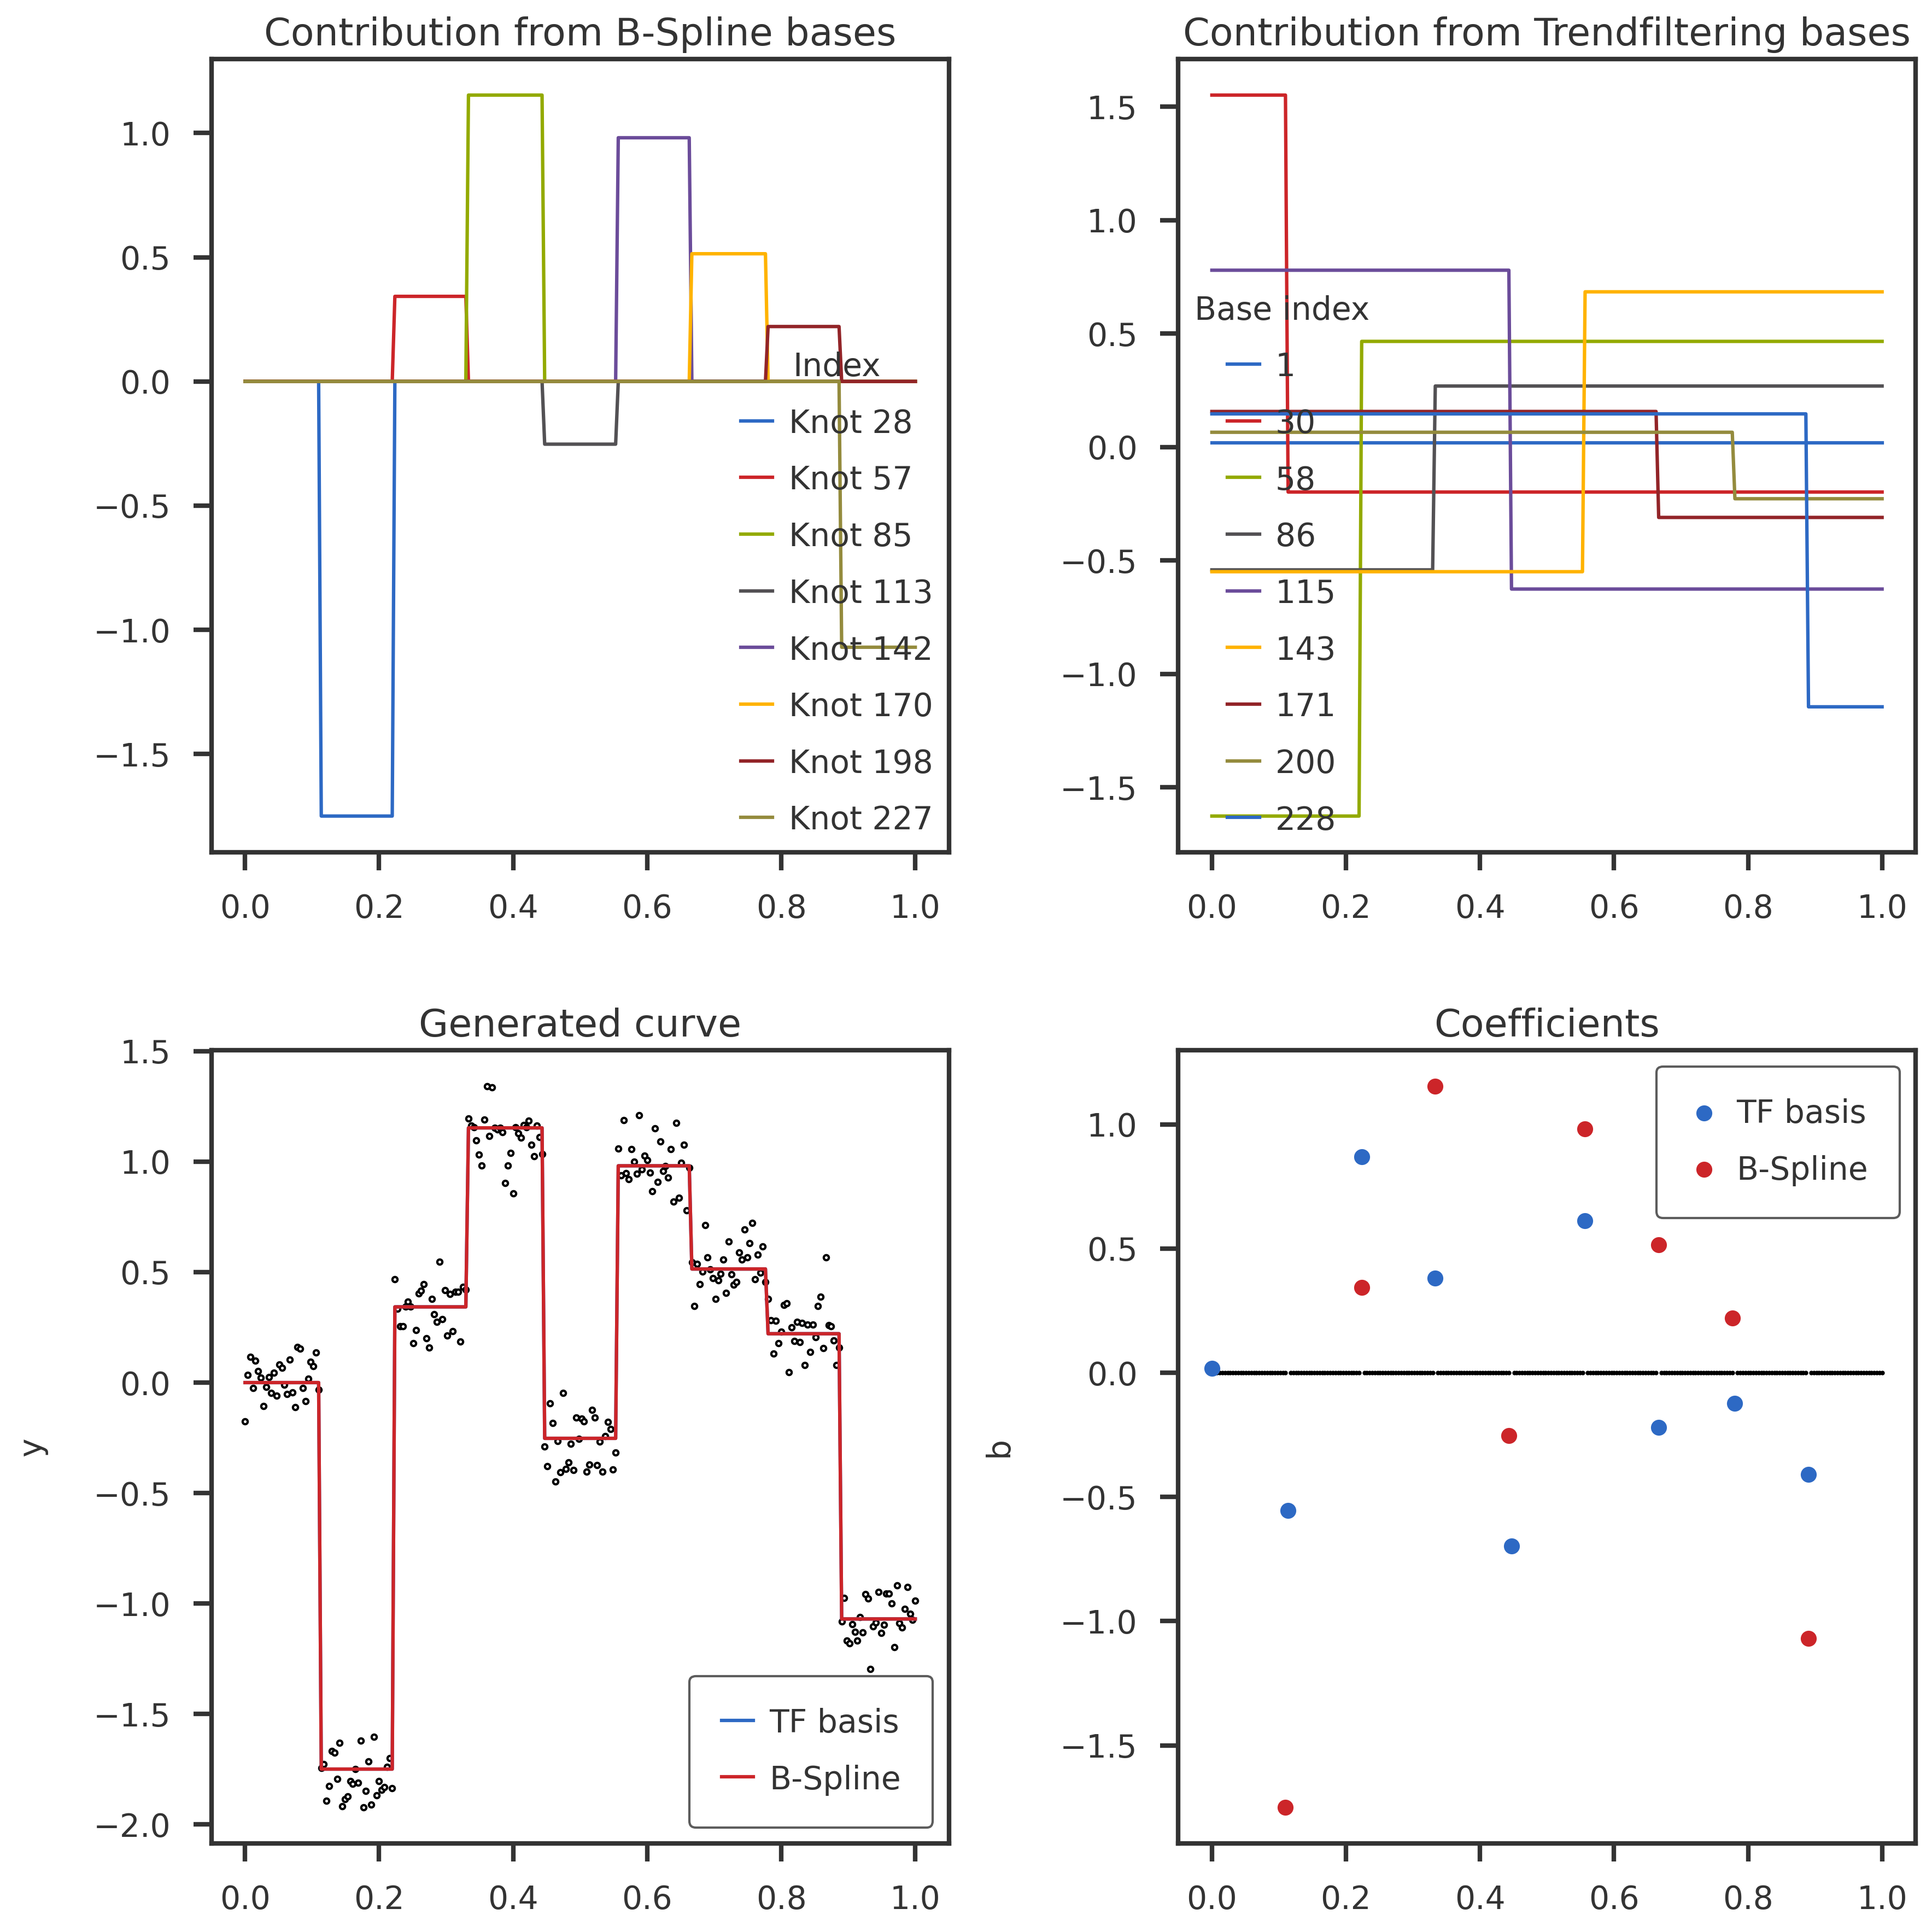

In [4]:
fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, Hscale, bscale)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

In [5]:
tf_y, tf_fit = R_trendfilter.fit(y, order = degree)
tf_basis_inv = model.trendfiltering_basis_matrix_inverse(n, degree) 
tf_bhat  = np.dot(tf_basis_inv, tf_y)

R[write to console]: Loading required package: Matrix



Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [6]:
k = 10
scale = 2.0
s2init = np.var(y - np.dot(H, tf_bhat))
_, binit = center_and_scale_tfbasis(H, tf_bhat)
winit, sk = initialize_ash_prior(k, scale = scale, sparsity = 0.8)
print (r"Standard deviation of components in Gaussian scale mixture:")
print (', '.join([f"{x:.3f}" for x in sk]))
print ()
print ("Coefficients of components in Gaussian scale mixture (initial values):")
print (', '.join([f"{x:.3f}" for x in winit]))

Standard deviation of components in Gaussian scale mixture:
0.000, 0.072, 0.149, 0.231, 0.320, 0.414, 0.516, 0.625, 0.741, 0.866

Coefficients of components in Gaussian scale mixture (initial values):
0.800, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022, 0.022


In [7]:
'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "rds", debug = False)
mrash_r.fit(Hscale, y, sk, binit = binit, winit = winit, s2init = s2init)

2022-04-06 11:04:18,861 | mrashpen.inference.mrash_wrapR | INFO | Mr.ASH terminated at iteration 126.



In [8]:
'''
mr.ash.pen
'''
plr_lbfgs_noinit = PLR(method = 'L-BFGS-B', is_prior_scaled = True, function_call = 'fortran',
                debug = False, display_progress = False, calculate_elbo = True,
                maxiter = 2000, tol = 1e-8)
plr_lbfgs_noinit.fit(Hscale, y, sk, binit = binit, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 483.


In [ ]:
'''
mr.ash.pen (inverse)
'''
import mrashpen_inverse
from scipy import optimize as sp_optimize

def plr_obj_func_Minv(params, X, y, sk, s2, dj, softmax_base = np.exp(1)):
    n, p = X.shape
    k = sk.shape[0]
    b = params[:p]
    a = params[p:]
    r = y - np.dot(X, b)
    rTr = np.dot(r, r)
    Pb, dPdb, dPda = mrashpen_inverse.penalty_func(b, a, np.sqrt(s2), sk, dj,
                                    jac = True, 
                                    softmax_base = softmax_base, 
                                    method = 'fssi-cubic',
                                    ngrid = 1000)
    H = 0.5 * rTr / s2 + Pb
    dHdb = - np.dot(r.T, X) / s2
    dHdb += dPdb
    return H, np.concatenate((dHdb, dPda))

ainit = np.log(winit)
initparams = np.concatenate((binit, ainit))
opt_min = sp_optimize.minimize(plr_obj_func_Minv, initparams,
                               args = (Hscale, y, sk, s2init, dj),
                               method = 'l-bfgs-b', jac = True,
                               #options = {'disp': True, 'maxiter': 10, 'return_all': True}
                               options = {'disp':True, 'maxiter': 2000}
                              )

In [17]:
'''
mr.ash.pen (inverse)
'''
import mrashpen_inverse
from scipy import optimize as sp_optimize

def plr_obj_func_Minv(params, X, y, sk, s2, dj, softmax_base = np.exp(1)):
    n, p = X.shape
    k = sk.shape[0]
    b = params[:p]
    a = params[p:]
    r = y - np.dot(X, b)
    rTr = np.dot(r, r)
    Pb, dPdb, dPda = mrashpen_inverse.penalty_func(b, a, np.sqrt(s2), sk, dj,
                                    jac = True, 
                                    softmax_base = softmax_base, 
                                    method = 'fssi-cubic',
                                    ngrid = 1000)
    H = 0.5 * rTr / s2 + Pb
    dHdb = - np.dot(r.T, X) / s2
    dHdb += dPdb
    return H, np.concatenate((dHdb, dPda))

ainit = np.log(winit)
initparams = np.concatenate((binit, ainit))
opt_min = sp_optimize.minimize(plr_obj_func_Minv, initparams,
                               args = (Hscale, y, sk, s2init, dj),
                               method = 'l-bfgs-b', jac = True,
                               #options = {'disp': True, 'maxiter': 10, 'return_all': True}
                               options = {'disp':True, 'maxiter': 2000}
                              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          266     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.45884D+02    |proj g|=  1.16589D+03

At iterate    1    f= -6.50357D+02    |proj g|=  1.11086D+03

At iterate    2    f= -6.56140D+02    |proj g|=  1.09248D+03

At iterate    3    f= -6.57859D+02    |proj g|=  1.07977D+03

At iterate    4    f= -6.65840D+02    |proj g|=  9.56428D+02

At iterate    5    f= -6.74180D+02    |proj g|=  7.66355D+02

At iterate    6    f= -6.89686D+02    |proj g|=  3.54376D+02

At iterate    7    f= -6.94904D+02    |proj g|=  3.05687D+02

At iterate    8    f= -7.02535D+02    |proj g|=  2.77859D+02

At iterate    9    f= -7.04625D+02    |proj g|=  4.80887D+02

At iterate   10    f= -7.05708D+02    |proj g|=  1.85975D+02

At iterate   11    f= -7.07518D+02    |proj g|=  1.33187D+02

At iterate   12    f= -7.08565D+02    |proj g|=  2.43647D+02

At iterate   13    f= -7.0

 This problem is unconstrained.



At iterate   17    f= -7.12274D+02    |proj g|=  1.37581D+02

At iterate   18    f= -7.13304D+02    |proj g|=  2.69631D+02

At iterate   19    f= -7.15378D+02    |proj g|=  2.63266D+02

At iterate   20    f= -7.17698D+02    |proj g|=  2.96889D+02

At iterate   21    f= -7.18901D+02    |proj g|=  2.54802D+02

At iterate   22    f= -7.19021D+02    |proj g|=  2.67698D+02

At iterate   23    f= -7.20247D+02    |proj g|=  2.11946D+02

At iterate   24    f= -7.21044D+02    |proj g|=  1.33307D+02

At iterate   25    f= -7.21181D+02    |proj g|=  2.13922D+02

At iterate   26    f= -7.21378D+02    |proj g|=  1.39498D+02

At iterate   27    f= -7.21723D+02    |proj g|=  1.68986D+02

At iterate   28    f= -7.21909D+02    |proj g|=  1.07485D+02

At iterate   29    f= -7.22115D+02    |proj g|=  1.55088D+02

At iterate   30    f= -7.22859D+02    |proj g|=  2.12910D+02

At iterate   31    f= -7.23292D+02    |proj g|=  1.69531D+02

At iterate   32    f= -7.23553D+02    |proj g|=  3.20736D+02

At iter


At iterate  158    f= -7.48233D+02    |proj g|=  4.83656D+01

At iterate  159    f= -7.48251D+02    |proj g|=  2.81633D+01

At iterate  160    f= -7.48265D+02    |proj g|=  2.37742D+01

At iterate  161    f= -7.48284D+02    |proj g|=  3.86385D+01

At iterate  162    f= -7.48314D+02    |proj g|=  7.29349D+01

At iterate  163    f= -7.48364D+02    |proj g|=  9.97396D+01

At iterate  164    f= -7.48417D+02    |proj g|=  6.36106D+01

At iterate  165    f= -7.48441D+02    |proj g|=  2.70501D+01

At iterate  166    f= -7.48451D+02    |proj g|=  2.84934D+01

At iterate  167    f= -7.48458D+02    |proj g|=  3.61065D+01

At iterate  168    f= -7.48477D+02    |proj g|=  7.23161D+01

At iterate  169    f= -7.48506D+02    |proj g|=  6.32599D+01

At iterate  170    f= -7.48544D+02    |proj g|=  6.23664D+01

At iterate  171    f= -7.48566D+02    |proj g|=  6.15794D+01

At iterate  172    f= -7.48594D+02    |proj g|=  5.95035D+01

At iterate  173    f= -7.48651D+02    |proj g|=  7.78782D+01

At iter


At iterate  297    f= -7.52122D+02    |proj g|=  1.63835D+01

At iterate  298    f= -7.52125D+02    |proj g|=  2.14651D+01

At iterate  299    f= -7.52131D+02    |proj g|=  7.58537D+01

At iterate  300    f= -7.52144D+02    |proj g|=  1.00414D+02

At iterate  301    f= -7.52170D+02    |proj g|=  7.21815D+01

At iterate  302    f= -7.52181D+02    |proj g|=  8.96538D+01

At iterate  303    f= -7.52196D+02    |proj g|=  5.82093D+01

At iterate  304    f= -7.52207D+02    |proj g|=  3.40933D+01

At iterate  305    f= -7.52222D+02    |proj g|=  2.91926D+01

At iterate  306    f= -7.52227D+02    |proj g|=  5.53748D+01

At iterate  307    f= -7.52239D+02    |proj g|=  5.21227D+01

At iterate  308    f= -7.52245D+02    |proj g|=  4.56000D+01

At iterate  309    f= -7.52252D+02    |proj g|=  3.10613D+01

At iterate  310    f= -7.52260D+02    |proj g|=  2.37850D+01

At iterate  311    f= -7.52264D+02    |proj g|=  2.71033D+01

At iterate  312    f= -7.52266D+02    |proj g|=  2.24926D+01

At iter


At iterate  437    f= -7.58957D+02    |proj g|=  3.31893D+01

At iterate  438    f= -7.58971D+02    |proj g|=  5.53510D+01

At iterate  439    f= -7.58986D+02    |proj g|=  5.28848D+01

At iterate  440    f= -7.59003D+02    |proj g|=  5.65321D+01

At iterate  441    f= -7.59047D+02    |proj g|=  1.03734D+02

At iterate  442    f= -7.59055D+02    |proj g|=  1.25351D+02

At iterate  443    f= -7.59102D+02    |proj g|=  1.11236D+02

At iterate  444    f= -7.59120D+02    |proj g|=  8.76726D+01

At iterate  445    f= -7.59143D+02    |proj g|=  1.27856D+02

At iterate  446    f= -7.59157D+02    |proj g|=  3.99457D+01

At iterate  447    f= -7.59173D+02    |proj g|=  4.15705D+01

At iterate  448    f= -7.59205D+02    |proj g|=  5.51841D+01

At iterate  449    f= -7.59236D+02    |proj g|=  8.41167D+01

At iterate  450    f= -7.59278D+02    |proj g|=  1.33905D+02

At iterate  451    f= -7.59328D+02    |proj g|=  6.97809D+01

At iterate  452    f= -7.59348D+02    |proj g|=  8.06947D+01

At iter


At iterate  575    f= -7.60441D+02    |proj g|=  1.09134D+01

At iterate  576    f= -7.60443D+02    |proj g|=  1.33923D+01

At iterate  577    f= -7.60444D+02    |proj g|=  1.95070D+01

At iterate  578    f= -7.60446D+02    |proj g|=  2.25354D+01

At iterate  579    f= -7.60449D+02    |proj g|=  2.61973D+01

At iterate  580    f= -7.60452D+02    |proj g|=  2.78354D+01

At iterate  581    f= -7.60457D+02    |proj g|=  2.28266D+01

At iterate  582    f= -7.60458D+02    |proj g|=  1.63662D+01

At iterate  583    f= -7.60460D+02    |proj g|=  1.92316D+01

At iterate  584    f= -7.60461D+02    |proj g|=  1.61103D+01

At iterate  585    f= -7.60462D+02    |proj g|=  1.48853D+01

At iterate  586    f= -7.60463D+02    |proj g|=  1.05951D+01

At iterate  587    f= -7.60464D+02    |proj g|=  7.60765D+00

At iterate  588    f= -7.60464D+02    |proj g|=  7.74477D+00

At iterate  589    f= -7.60464D+02    |proj g|=  6.65892D+00

At iterate  590    f= -7.60465D+02    |proj g|=  5.73523D+00

At iter


At iterate  713    f= -7.60532D+02    |proj g|=  1.42367D+01

At iterate  714    f= -7.60534D+02    |proj g|=  2.23326D+01

At iterate  715    f= -7.60538D+02    |proj g|=  3.27845D+01

At iterate  716    f= -7.60541D+02    |proj g|=  3.95635D+01

At iterate  717    f= -7.60545D+02    |proj g|=  1.39608D+01

At iterate  718    f= -7.60547D+02    |proj g|=  8.08565D+00

At iterate  719    f= -7.60547D+02    |proj g|=  8.14827D+00

At iterate  720    f= -7.60547D+02    |proj g|=  9.40556D+00

At iterate  721    f= -7.60549D+02    |proj g|=  1.21250D+01

At iterate  722    f= -7.60551D+02    |proj g|=  3.22700D+01

At iterate  723    f= -7.60554D+02    |proj g|=  5.67584D+01

At iterate  724    f= -7.60560D+02    |proj g|=  4.55134D+01

At iterate  725    f= -7.60566D+02    |proj g|=  1.85854D+01

At iterate  726    f= -7.60567D+02    |proj g|=  1.44854D+01

At iterate  727    f= -7.60569D+02    |proj g|=  1.53345D+01

At iterate  728    f= -7.60572D+02    |proj g|=  2.91417D+01

At iter


At iterate  852    f= -7.61661D+02    |proj g|=  5.67945D+01

At iterate  853    f= -7.61668D+02    |proj g|=  6.35297D+01

At iterate  854    f= -7.61672D+02    |proj g|=  4.41103D+01

At iterate  855    f= -7.61678D+02    |proj g|=  5.15461D+01

At iterate  856    f= -7.61687D+02    |proj g|=  5.47771D+01

At iterate  857    f= -7.61692D+02    |proj g|=  5.93860D+01

At iterate  858    f= -7.61701D+02    |proj g|=  1.06316D+02

At iterate  859    f= -7.61714D+02    |proj g|=  7.62354D+01

At iterate  860    f= -7.61721D+02    |proj g|=  1.07060D+02

At iterate  861    f= -7.61729D+02    |proj g|=  5.65599D+01

At iterate  862    f= -7.61739D+02    |proj g|=  5.40140D+01

At iterate  863    f= -7.61745D+02    |proj g|=  7.16691D+01

At iterate  864    f= -7.61753D+02    |proj g|=  2.98325D+01

At iterate  865    f= -7.61757D+02    |proj g|=  4.12123D+01

At iterate  866    f= -7.61759D+02    |proj g|=  4.75597D+01

At iterate  867    f= -7.61764D+02    |proj g|=  4.47739D+01

At iter


At iterate  998    f= -7.62002D+02    |proj g|=  2.97863D+01

At iterate  999    f= -7.62004D+02    |proj g|=  2.65735D+01

At iterate 1000    f= -7.62008D+02    |proj g|=  3.06147D+01

At iterate 1001    f= -7.62010D+02    |proj g|=  4.15872D+01

At iterate 1002    f= -7.62012D+02    |proj g|=  2.30441D+01

At iterate 1003    f= -7.62013D+02    |proj g|=  2.29212D+01

At iterate 1004    f= -7.62014D+02    |proj g|=  3.21392D+01

At iterate 1005    f= -7.62017D+02    |proj g|=  4.23063D+01

At iterate 1006    f= -7.62023D+02    |proj g|=  8.90750D+01

At iterate 1007    f= -7.62033D+02    |proj g|=  8.79590D+01

At iterate 1008    f= -7.62040D+02    |proj g|=  5.58303D+01

At iterate 1009    f= -7.62043D+02    |proj g|=  1.52558D+01

At iterate 1010    f= -7.62043D+02    |proj g|=  1.43571D+01

At iterate 1011    f= -7.62044D+02    |proj g|=  1.42354D+01

At iterate 1012    f= -7.62045D+02    |proj g|=  2.21055D+01

At iterate 1013    f= -7.62046D+02    |proj g|=  3.00629D+01

At iter


At iterate 1140    f= -7.62427D+02    |proj g|=  3.62400D+01

At iterate 1141    f= -7.62433D+02    |proj g|=  1.22040D+02

At iterate 1142    f= -7.62441D+02    |proj g|=  5.25329D+01

At iterate 1143    f= -7.62444D+02    |proj g|=  3.99211D+01

At iterate 1144    f= -7.62447D+02    |proj g|=  5.52584D+01

At iterate 1145    f= -7.62450D+02    |proj g|=  3.28230D+01

At iterate 1146    f= -7.62451D+02    |proj g|=  2.15421D+01

At iterate 1147    f= -7.62452D+02    |proj g|=  2.13566D+01

At iterate 1148    f= -7.62453D+02    |proj g|=  3.05686D+01

At iterate 1149    f= -7.62456D+02    |proj g|=  4.96868D+01

At iterate 1150    f= -7.62460D+02    |proj g|=  6.42370D+01

At iterate 1151    f= -7.62461D+02    |proj g|=  1.23061D+02

At iterate 1152    f= -7.62467D+02    |proj g|=  5.68976D+01

At iterate 1153    f= -7.62471D+02    |proj g|=  5.47496D+01

At iterate 1154    f= -7.62473D+02    |proj g|=  4.62961D+01

At iterate 1155    f= -7.62476D+02    |proj g|=  4.27701D+01

At iter


At iterate 1279    f= -7.62705D+02    |proj g|=  2.62777D+01

At iterate 1280    f= -7.62706D+02    |proj g|=  2.64687D+01

At iterate 1281    f= -7.62709D+02    |proj g|=  4.46781D+01

At iterate 1282    f= -7.62711D+02    |proj g|=  6.58207D+01

At iterate 1283    f= -7.62714D+02    |proj g|=  3.19295D+01

At iterate 1284    f= -7.62716D+02    |proj g|=  3.88876D+01

At iterate 1285    f= -7.62720D+02    |proj g|=  4.64225D+01

At iterate 1286    f= -7.62724D+02    |proj g|=  6.01923D+01

At iterate 1287    f= -7.62731D+02    |proj g|=  5.75782D+01

At iterate 1288    f= -7.62740D+02    |proj g|=  6.83930D+01

At iterate 1289    f= -7.62752D+02    |proj g|=  1.05910D+02

At iterate 1290    f= -7.62759D+02    |proj g|=  1.04565D+02

At iterate 1291    f= -7.62768D+02    |proj g|=  7.47027D+01

At iterate 1292    f= -7.62771D+02    |proj g|=  6.58511D+01

At iterate 1293    f= -7.62775D+02    |proj g|=  6.29343D+01

At iterate 1294    f= -7.62783D+02    |proj g|=  9.43208D+01

At iter


At iterate 1421    f= -7.63665D+02    |proj g|=  4.56221D+01

At iterate 1422    f= -7.63666D+02    |proj g|=  4.16880D+01

At iterate 1423    f= -7.63669D+02    |proj g|=  2.61185D+01

At iterate 1424    f= -7.63671D+02    |proj g|=  4.47515D+01

At iterate 1425    f= -7.63676D+02    |proj g|=  4.96076D+01

At iterate 1426    f= -7.63682D+02    |proj g|=  4.05255D+01

At iterate 1427    f= -7.63689D+02    |proj g|=  2.72532D+01

At iterate 1428    f= -7.63693D+02    |proj g|=  3.50922D+01

At iterate 1429    f= -7.63695D+02    |proj g|=  4.01067D+01

At iterate 1430    f= -7.63697D+02    |proj g|=  2.81335D+01

At iterate 1431    f= -7.63699D+02    |proj g|=  1.93110D+01

At iterate 1432    f= -7.63700D+02    |proj g|=  2.00971D+01

At iterate 1433    f= -7.63701D+02    |proj g|=  2.20242D+01

At iterate 1434    f= -7.63702D+02    |proj g|=  1.96425D+01

At iterate 1435    f= -7.63703D+02    |proj g|=  1.89853D+01

At iterate 1436    f= -7.63705D+02    |proj g|=  2.35190D+01

At iter


At iterate 1559    f= -7.63756D+02    |proj g|=  8.36879D+00

At iterate 1560    f= -7.63756D+02    |proj g|=  6.94122D+00

At iterate 1561    f= -7.63756D+02    |proj g|=  3.17372D+00

At iterate 1562    f= -7.63756D+02    |proj g|=  3.15861D+00

At iterate 1563    f= -7.63756D+02    |proj g|=  3.13005D+00

At iterate 1564    f= -7.63756D+02    |proj g|=  5.13052D+00

At iterate 1565    f= -7.63756D+02    |proj g|=  7.19983D+00

At iterate 1566    f= -7.63756D+02    |proj g|=  3.79655D+00

At iterate 1567    f= -7.63756D+02    |proj g|=  3.15943D+00

At iterate 1568    f= -7.63756D+02    |proj g|=  2.46074D+00

At iterate 1569    f= -7.63756D+02    |proj g|=  3.34530D+00

At iterate 1570    f= -7.63756D+02    |proj g|=  4.02570D+00

At iterate 1571    f= -7.63756D+02    |proj g|=  1.79798D+00

At iterate 1572    f= -7.63756D+02    |proj g|=  1.61038D+00

At iterate 1573    f= -7.63756D+02    |proj g|=  1.89753D+00

At iterate 1574    f= -7.63756D+02    |proj g|=  2.98989D+00

At iter


At iterate 1708    f= -7.63759D+02    |proj g|=  1.24832D+00

At iterate 1709    f= -7.63759D+02    |proj g|=  2.04361D+00

At iterate 1710    f= -7.63759D+02    |proj g|=  2.09779D+00

At iterate 1711    f= -7.63759D+02    |proj g|=  2.17972D+00

At iterate 1712    f= -7.63759D+02    |proj g|=  2.32299D+00

At iterate 1713    f= -7.63759D+02    |proj g|=  3.26963D+00

At iterate 1714    f= -7.63759D+02    |proj g|=  5.28946D+00

At iterate 1715    f= -7.63759D+02    |proj g|=  9.30242D+00

At iterate 1716    f= -7.63759D+02    |proj g|=  1.14007D+01

At iterate 1717    f= -7.63759D+02    |proj g|=  6.49782D+00

At iterate 1718    f= -7.63759D+02    |proj g|=  2.77204D+00

At iterate 1719    f= -7.63759D+02    |proj g|=  1.82186D+00

At iterate 1720    f= -7.63759D+02    |proj g|=  1.81560D+00

At iterate 1721    f= -7.63759D+02    |proj g|=  5.33144D+00

At iterate 1722    f= -7.63759D+02    |proj g|=  8.81431D+00

At iterate 1723    f= -7.63759D+02    |proj g|=  1.15392D+01

At iter


At iterate 1852    f= -7.63768D+02    |proj g|=  2.33011D+00

At iterate 1853    f= -7.63768D+02    |proj g|=  3.92813D+00

At iterate 1854    f= -7.63768D+02    |proj g|=  2.94088D+00

At iterate 1855    f= -7.63768D+02    |proj g|=  9.68346D+00

At iterate 1856    f= -7.63768D+02    |proj g|=  1.94359D+00

At iterate 1857    f= -7.63768D+02    |proj g|=  1.42730D+00

At iterate 1858    f= -7.63768D+02    |proj g|=  1.42517D+00

At iterate 1859    f= -7.63768D+02    |proj g|=  1.73699D+00

At iterate 1860    f= -7.63768D+02    |proj g|=  2.82700D+00

At iterate 1861    f= -7.63768D+02    |proj g|=  3.63925D+00

At iterate 1862    f= -7.63768D+02    |proj g|=  2.97563D+00

At iterate 1863    f= -7.63768D+02    |proj g|=  3.31073D+00

At iterate 1864    f= -7.63768D+02    |proj g|=  2.58789D+00

At iterate 1865    f= -7.63768D+02    |proj g|=  1.59272D+00

At iterate 1866    f= -7.63768D+02    |proj g|=  1.28165D+00

At iterate 1867    f= -7.63768D+02    |proj g|=  1.39509D+00

At iter

In [23]:
bhat = opt_min.x[:binit.shape[0]]
what = mrashpen_inverse.softmax(opt_min.x[binit.shape[0]:])

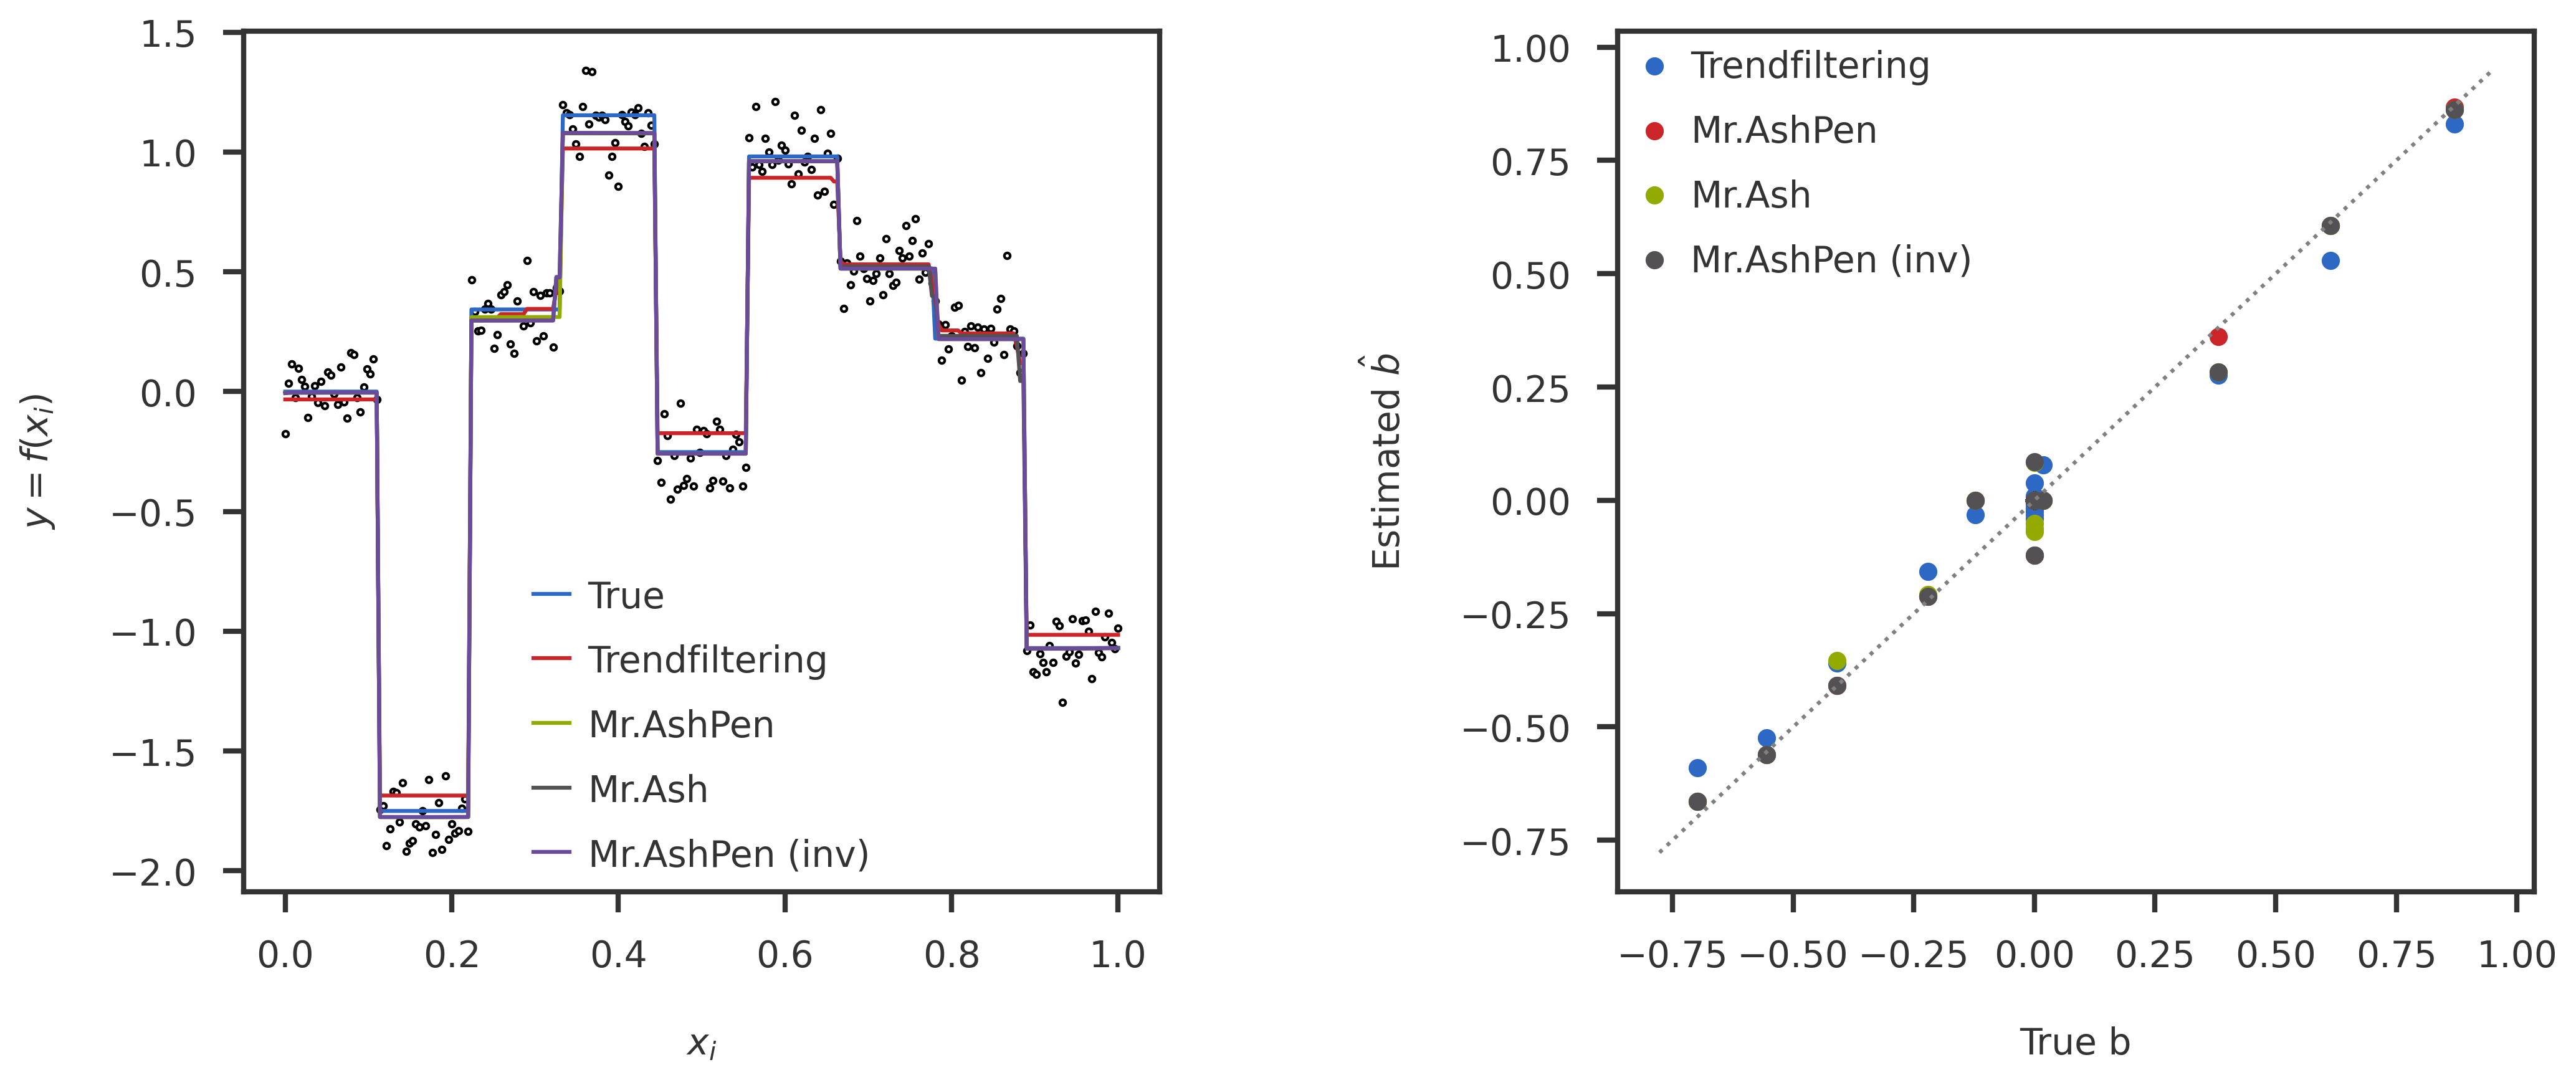

In [26]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(x, y, s = 5, edgecolor = 'black', facecolor='white')
ax1.plot(x, np.dot(H, btrue), label = "True")
ax1.plot(x, tf_y, label = "Trendfiltering")
ax1.plot(x, np.dot(Hscale, plr_lbfgs_noinit.coef), label = "Mr.AshPen")
ax1.plot(x, np.dot(Hscale, mrash_r.coef), label = "Mr.Ash")
ax1.plot(x, np.dot(Hscale, bhat), label = "Mr.AshPen (inv)")
ax1.legend()

ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")
ax2.scatter(bscale, binit, label = "Trendfiltering")
ax2.scatter(bscale, plr_lbfgs_noinit.coef, label = "Mr.AshPen")
ax2.scatter(bscale, mrash_r.coef, label = "Mr.Ash")
ax2.scatter(bscale, bhat, label = "Mr.AshPen (inv)")
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("True b")
ax2.set_ylabel(r"Estimated $\hat{b}$")
ax2.legend()
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

# fig = plt.figure(figsize = (12, 6))
# ax1 = fig.add_subplot(111)
# objs = [mrash_r.obj_path, plr_lbfgs_noinit.elbo_path]
# methods = ["Mr.Ash", "Mr.AshPen"]
# nwarm = [0, 0]
# objmin  = np.min([np.min(x) for x in objs])
# for obj, method, iteq in zip(objs, methods, nwarm):
#     m_obj = np.array(obj)[iteq:] - objmin
#     m_obj = m_obj[m_obj > 0]
#     ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
#              marker = 'o', markersize = 1)
# ax1.legend()
# ax1.set_xlabel("Number of Iterations")
# ax1.set_ylabel("log( max(ELBO) - ELBO )")
# plt.show()

### Coefficients of components in Gaussian scale mixture

In [36]:
print ("Mr.Ash:")
print (', '.join([f"{x:.3f}" for x in mrash_r.prior[:, 0]]))
print ()

print ("Mr.AshPen:")
print (', '.join([f"{x:.3f}" for x in plr_lbfgs_noinit.prior]))
print ()

print ("Mr.AshPen (using M-inverse):")
print (', '.join([f"{x:.3f}" for x in what]))
print ()

Mr.Ash:
0.953, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.047

Mr.AshPen:
0.966, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.034

Mr.AshPen (using M-inverse):
0.961, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.038



In [30]:
mrash_r.prior

array([[9.53328002e-01],
       [2.10088875e-12],
       [8.93068935e-13],
       [1.09643494e-12],
       [1.43502408e-12],
       [1.48533678e-12],
       [1.35957654e-12],
       [1.27954270e-12],
       [1.42782160e-12],
       [4.66719976e-02]])